# Model Failure Explanations for Regression

**Example.** In this example, we create a model to forecast GDP growth based on macroeconomic variables, then ask why it fails to predict the 2008-2009 financial crisis. We find that a high volume of real estate loans as a percent of GDP in 2007-2008 was detrimental to model performance. 

**General formulation.** More generally, we can ask why our model performed poorly on sample $X$, as measured by loss function $L$. Here, our sample is the years 2008-2009, and our loss function is $R^2$.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.datasets import load_gdp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor as KNeighborsRegressorMixin

import os
import random
from datetime import datetime

np.random.seed(0)
random.seed(0)

# directory for saving figures
# set to `None` to avoid saving
PLOT_DIR = 'plots'

**Model.** We train a model on a GDP dataset with annual data, in which we produce 1-year ahead GDP growth forecasts based on 6 macroeconomic variables: growth in government expenditure, investment, consumption, exports, and imports, and real estate loans from commercial banks as a percent of GDP. Our model first uses principal components analysis to reduce our data to 5 dimensions, then applies a K-nearest neighbors algorithm with 4 neighbors. The number of principal components and neighbors were tuned using Scikit-learn's grid search, training on data from 1975-1990 and validating on data from 1991-2007. Our model achieves a validation $R^2$ of .26. Retraining the model on the full training dataset (1975-2007), we achieve a training $R^2$ of .40. However, our forecasts for 2008-2009 perform worse than chance: $R^2=-3.13$.

For brevity, the hyperparameter tuning code is in a separate notebook.

In [2]:
# define a version of KNN which begins by running PCA on input data
class KNeighborsRegressor(KNeighborsRegressorMixin):
    def __init__(self, n_neighbors=4, n_components=5):
        super().__init__(n_neighbors)
        self.n_components = n_components
        
    def fit(self, X, y):
        self.pca = PCA(n_components=self.n_components)
        X = self.pca.fit_transform(X)
        return super().fit(X, y)
    
    def predict(self, X):
        X = self.pca.transform(X)
        return super().predict(X)

# load the GDP dataset
gdp = load_gdp()
X, y = gdp.data, gdp.target.iloc[1:]

# lag the X variables by 1 time step (1 year)
X, date = X.drop('date', axis=1), pd.to_datetime(X['date']).iloc[1:]
X_lagged = X.shift(1).iloc[1:]

# train on years 1975-2007; predict on 2008-2009
train_idx = date < datetime(2008, 1, 1)
test_idx = ~train_idx & (date <= datetime(2009, 1, 1))
X_train, X_test, y_train, y_test = (
    X_lagged[train_idx], X_lagged[test_idx],
    y[train_idx], y[test_idx]
) 

# training and evaluation
reg = KNeighborsRegressor().fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
print('Train score: % .4f' % r2_score(y_train, y_pred_train))
print('Test score: % .4f' % r2_score(y_test, y_pred_test))

Train score:  0.3958
Test score: -3.1278


From this figure, it is clear that our model fails to forecast the financial crisis.

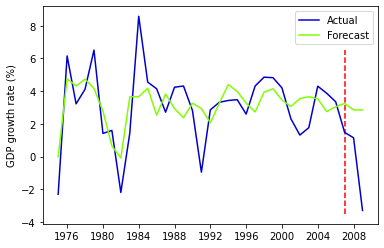

In [3]:
date_plt = date[date <= datetime(2009, 1, 1)]
y_plt = 100*np.concatenate((y_train, y_test))
y_pred_plt = 100*np.concatenate((y_pred_train, y_pred_test))
plt.plot(date_plt, y_plt, color='mediumblue')
plt.plot(date_plt, y_pred_plt, color='chartreuse')
plt.vlines(date_plt[y_train.shape[0]], -3.5, 6.5, color='r', linestyle='dashed')
plt.legend(('Actual', 'Forecast'))
plt.ylabel('GDP growth rate (%)')
if PLOT_DIR is not None:
    plt.savefig(os.path.join(PLOT_DIR, 'gdp_forecast.png'))
plt.show()

**G-SHAP values.** We compute the G-SHAP values, where $g$ is a loss function. In our case, the loss function is $R^2$.

\begin{equation}
    g(f,X,\Omega) = L(f,X,y)
    = 1-\frac
    {\sum_t (\%\Delta\text{GDP}_t - f(x_{t-1}))^2}
    {\sum_t (\%\Delta\text{GDP}_t - \overline{\%\Delta\text{GDP}})^2}
\end{equation}

Where additional arguments to $g$ are the labels for $X$; $\Omega=\{y\}$.

In [4]:
# performance on training data
g = lambda y_pred: r2_score(y_train, y_pred)
explainer_train = gshap.KernelExplainer(reg.predict, X_train, g)
gshap_values_train = explainer_train.gshap_values(X_train, nsamples=1000)

# performance on test data
g = lambda y_pred: r2_score(y_test, y_pred)
explainer_test = gshap.KernelExplainer(reg.predict, X_train, g)
gshap_values_test = explainer_test.gshap_values(X_test, nsamples=1000)

**Interpretation.** For interpretation, we make two comparisons. First, we compare the training data $X_\text{train}=\{x_{t-1} : t=1975...2007\}$ to a background dataset $Z$ (the shuffled training data) in terms of $g$ using training labels; $y_\text{train}=\{\%\Delta\text{GDP}_t : t=1975...2007\}$. Second, we compare the test data $X_\text{test}=\{x_{t-1} : t=2008,2009\}$ to $Z$ in terms of $g$ using test labels; $y_\text{test}=\{\%\Delta\text{GDP}_t : t=2008,2009\}$. By making these two comparisons, we can see the extent to which feature $j$ contributed to model performance for the training data, and the extent to which feature $j$ contributed to model performance for the test data. If feature $j$'s contribution diminished between the training and test data, we can conclude it was responsible for our model's poor test performance. A negative G-SHAP value indicates that feature $j$ degraded performance.

In the first comparison, our model's $R^2$ is .40 for the training data and -.28 for the background data. Each G-SHAP value $\phi_g^j$ is the amount of this difference (.68) explained by feature $j$. We interpret the G-SHAP values for the test data comparison comparison similarly.

For model failure explanations more broadly, our model has a loss $L(f,X,y)$ for our test sample and $L(f,Z,y)$ for the background data. Each G-SHAP value $\phi_g^j$ is the amount of this difference $L(f,X,y)-L(f,Z,y)$ explained by feature $j$.

In [5]:
g_comparison, g_background = explainer_train.compare(X_train, bootstrap_samples=1000)
print('R-squared for the training data: %.4f' % g_comparison)
print('R-squared for the shuffled background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_train.sum())

R-squared for the training data: 0.3958
R-squared for the shuffled background data: -0.2847
Sum of G-SHAP values: 0.6736


In [6]:
g_comparison, g_background = explainer_test.compare(X_test, bootstrap_samples=1000)
print('R-squared for the test data: %.4f' % g_comparison)
print('R-squared for the shuffled background data: %.4f' % g_background)
print('Sum of the G-SHAP values: %.4f' % gshap_values_test.sum())

R-squared for the test data: -3.1278
R-squared for the shuffled background data: -3.9406
Sum of the G-SHAP values: 0.8859


**Results.** This plot tells us which features contribute most to model performance. Because the performance of the background dataset differs in terms of $g$ when using the training versus test labels, we normalize the G-SHAP values to sum to 1 in order to compare performance. We see that real estate loans as a percent of GDP in 2007-2008 decreased the $R^2$ of our model's 2008-2009 GDP growth forecast by 34\%.

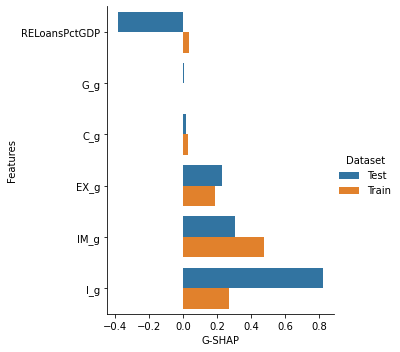

In [7]:
df = pd.DataFrame({
    'Features': X.columns,
    'Train': gshap_values_train/gshap_values_train.sum(),
    'Test': gshap_values_test/gshap_values_test.sum(),
})
df = df.sort_values('Test')
df = pd.melt(
    df, 
    id_vars='Features',
    value_vars=['Test', 'Train'],
    var_name='Dataset',
    value_name='G-SHAP',
)
sns.catplot(
    x='G-SHAP',
    y='Features',
    hue='Dataset',
    data=df,
    kind='bar',
    orient='h'
)
if PLOT_DIR is not None:
    plt.savefig(os.path.join(PLOT_DIR, 'gdp_gshap.png'))
plt.show()